In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from actual import actual_effect
from IWLS import IWLS, adaptive_IWLS, adaptive_IWLS_ablation_W, adaptive_IWLS_ablation_N
from first_order import first_order, adaptive_first_order
from margin import margin

from target import target_value
from utility import data_generation

In [2]:
# general parameters
n = 3000
d = 100
k = 30

seeds = range(0, 20)
covs = [0.5, 1.3, 2.0, 3.5, 5.0, 7.0, 8.0, 9.0, 10.0]

targets = ["probability", "abs_probability", "test_loss", "abs_test_loss", "avg_abs_test_loss", "abs_avg_test_loss"]

methods = ["IWLS", "Adaptive IWLS", "Adaptive IWLS Ablation(W)", "Adaptive IWLS Ablation(N)", "Margin-based", "First-order", "Adaptive First-order"]
num_methods, num_covs, num_seeds = len(methods), len(covs), len(seeds)

In [3]:
def score_per_seed_cov(seed, cov, target):
    X_train, y_train, X_test, y_test = data_generation(n, d, cov, seed, target=target)

    original_value = target_value(X_train, y_train, X_test, y_test, target=target)

    ind_n, ind_p = margin(X_train, y_train)

    scores = np.array([
        actual_effect(X_train, y_train, X_test, y_test, IWLS(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS_ablation_W(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS_ablation_N(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        max(actual_effect(X_train, y_train, X_test, y_test, ind_n[:k], original_value, target=target), actual_effect(X_train, y_train, X_test, y_test, ind_p[:k], original_value, target=target)),
        actual_effect(X_train, y_train, X_test, y_test, first_order(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_first_order(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target)
    ])

    return scores

In [4]:
# ranks.shape = (num_methods, num_experiments)
def Borda_count(ranks, weights=[7, 6, 5, 4, 3, 2, 1]):
    num_methods, num_experiments = ranks.shape

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=int)

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(-1 * ranks[:, experiment_idx])

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = weights[rank]

    total_weighted_borda_count = weighted_borda_count.sum(axis=1)

    return total_weighted_borda_count

Target: probability


Target: abs_probability
Target: test_loss
Target: abs_test_loss
Target: avg_abs_test_loss
Target: abs_avg_test_loss


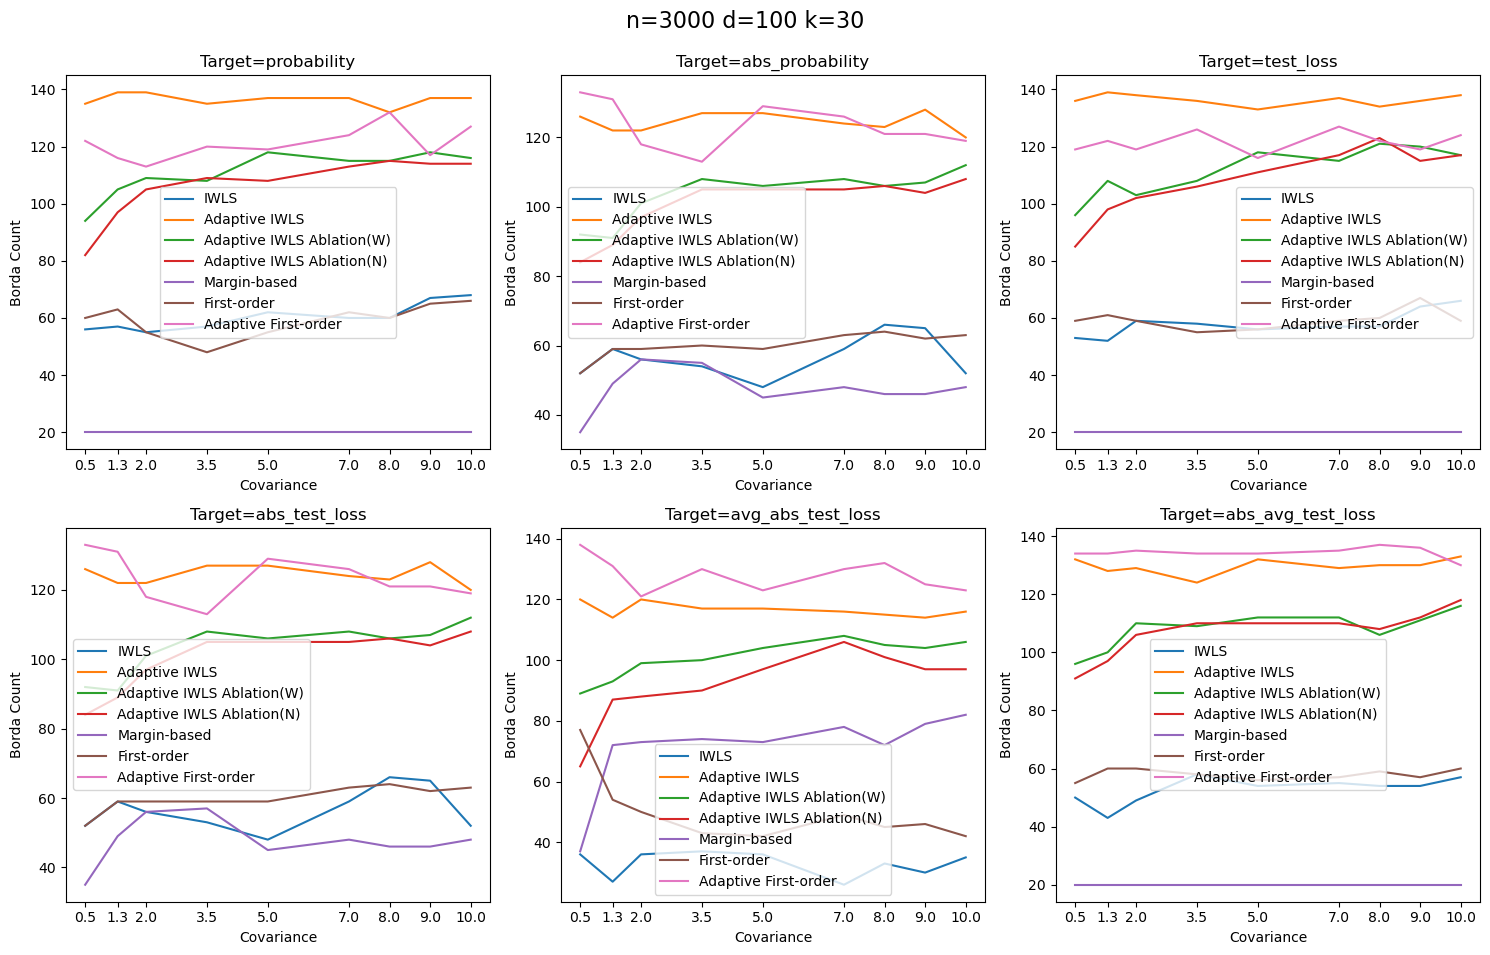

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

for target_idx, target in enumerate(targets):
    print(f"Target: {target}")
    scores_array = np.array(Parallel(n_jobs=20)(delayed(score_per_seed_cov)(seed, cov, target) for seed in seeds for cov in covs))
    scores_array = scores_array.reshape((num_seeds, num_covs, -1))

    scores_method_cov_seed = scores_array.swapaxes(0, 2) # method, cov, seed
    scores_cov_method_seed = scores_method_cov_seed.swapaxes(0, 1) # cov, method, seed

    Borda_result = np.zeros((num_covs, num_methods), dtype=float)

    Borda_result = np.array(Parallel(n_jobs=20)(delayed(Borda_count)(scores_cov_method_seed[cov_idx]) for cov_idx in range(num_covs)))

    # Plot in the corresponding subplot
    row_idx, col_idx = divmod(target_idx, 3)  # Calculate subplot index
    for method_idx, method_name in enumerate(methods):
        axs[row_idx, col_idx].plot(covs, Borda_result[:, method_idx], label=method_name)

    axs[row_idx, col_idx].set_title(f'Target={target}')
    axs[row_idx, col_idx].set_xlabel('Covariance')
    axs[row_idx, col_idx].set_ylabel('Borda Count')
    axs[row_idx, col_idx].legend(methods)

    axs[row_idx, col_idx].set_xticks(covs)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle(f'n={n} d={d} k={k}', fontsize=16)

plt.show()

In [6]:
def ratio_per_seed_cov(seed, cov, target):
    X_train, y_train, X_test, y_test = data_generation(n, d, cov, seed, target=target)

    original_value = target_value(X_train, y_train, X_test, y_test, target=target)

    ind_n, ind_p = margin(X_train, y_train)

    scores = np.array([
        actual_effect(X_train, y_train, X_test, y_test, IWLS(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS_ablation_W(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS_ablation_N(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        max(actual_effect(X_train, y_train, X_test, y_test, ind_n[:k], original_value, target=target), actual_effect(X_train, y_train, X_test, y_test, ind_p[:k], original_value, target=target)),
        actual_effect(X_train, y_train, X_test, y_test, first_order(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_first_order(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target)
    ])

    return np.array([
        scores[0] / scores[5],
        scores[1] / scores[5],
        scores[2] / scores[5],
        scores[3] / scores[5],
        scores[4] / scores[5],
        1,
        scores[5] / scores[6]
    ])

Target: probability


Target: abs_probability
Target: test_loss
Target: abs_test_loss
Target: avg_abs_test_loss
Target: abs_avg_test_loss


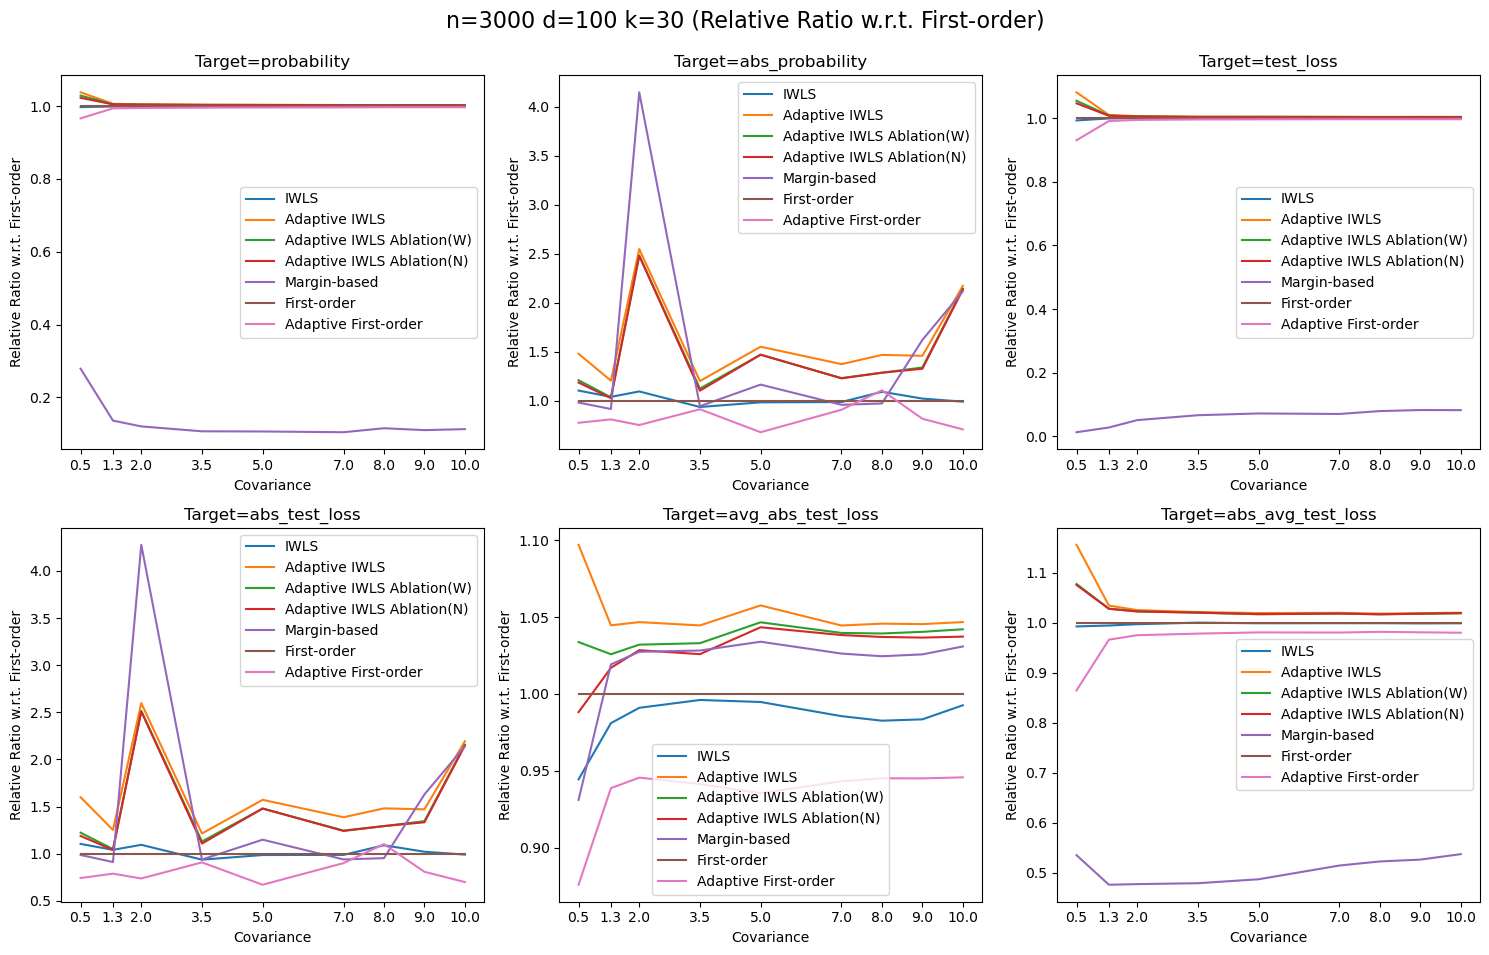

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

for target_idx, target in enumerate(targets):
    print(f"Target: {target}")
    ratio_array = np.array(Parallel(n_jobs=60)(delayed(ratio_per_seed_cov)(seed, cov, target) for seed in seeds for cov in covs))
    ratio_array = ratio_array.reshape((num_seeds, num_covs, -1))

    ratio_method_cov_seed = ratio_array.swapaxes(0, 2) # method, cov, seed
    ratio_cov_method_seed = ratio_method_cov_seed.swapaxes(0, 1) # cov, method, seed

    # ratio_result = np.zeros((num_covs, num_methods), dtype=float)

    ratio_result = ratio_cov_method_seed.mean(axis=2)

    # Plot in the corresponding subplot
    row_idx, col_idx = divmod(target_idx, 3)  # Calculate subplot index
    for method_idx, method_name in enumerate(methods):
        axs[row_idx, col_idx].plot(covs, ratio_result[:, method_idx], label=method_name)

    axs[row_idx, col_idx].set_title(f'Target={target}')
    axs[row_idx, col_idx].set_xlabel('Covariance')
    axs[row_idx, col_idx].set_ylabel('Relative Ratio w.r.t. First-order')
    axs[row_idx, col_idx].legend(methods)

    axs[row_idx, col_idx].set_xticks(covs)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle(f'n={n} d={d} k={k} (Relative Ratio w.r.t. First-order)', fontsize=16)

plt.show()